In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Fri Sep 10 08:38:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install --quiet transformers
!pip install --quiet pytorch-lightning

     |████████████████████████████████| 2.8 MB 6.6 MB/s 
     |████████████████████████████████| 3.3 MB 65.7 MB/s 
     |████████████████████████████████| 895 kB 67.7 MB/s 
     |████████████████████████████████| 50 kB 7.3 MB/s 
     |████████████████████████████████| 636 kB 90.0 MB/s 
     |████████████████████████████████| 919 kB 6.4 MB/s 
     |████████████████████████████████| 829 kB 59.1 MB/s 
     |████████████████████████████████| 282 kB 80.9 MB/s 
     |████████████████████████████████| 119 kB 83.8 MB/s 
     |████████████████████████████████| 1.3 MB 50.6 MB/s 
     |████████████████████████████████| 142 kB 76.7 MB/s 
     |████████████████████████████████| 294 kB 75.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline  
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

from collections import Counter

Global seed set to 42


In [ ]:
%ls drive/MyDrive/Biocreative/Biocreative/datasets/

 baseline/                   'scrapped tsv files'/
 BC7-LitCovid-Dev.csv         specter_data/
 BC7-LitCovid-Test.csv        specter_results/
 BC7-LitCovid-Train.csv       train.csv
 bigram_df.csv                TRAIN.csv
 bigram_df.xlsx               train_prac.csv
'dataset descriptions.xlsx'   train_t5.csv
 dev.csv                      transmission_bigram_dict.json
 Intro_rem_data/              Transmission.csv
'numpy checkpoints'/          TRUE_LABELS
 PRED_LABELS                  TRUES_LABELS
 PREDS_LABELS                 VAL.csv
 proxy_data/                  val_t5.csv
 sample_example.csv


In [ ]:
# import dataset
train_df = pd.read_csv('drive/MyDrive/Biocreative/Biocreative/datasets/Intro_rem_data/TRAIN_df.csv')
# train_df = train_df.sample(frac=1).reset_index(drop=True)
train_df.head(), train_df.shape

(       pmid  ... Treatment
 0  32519164  ...         1
 1  32691006  ...         1
 2  32858315  ...         0
 3  32985329  ...         0
 4  32812051  ...         1
 
 [5 rows x 11 columns], (31445, 11))

In [ ]:
train_df = train_df[~train_df.title.isna()]
train_df.shape

(31444, 11)

In [ ]:
train_df.columns

Index(['pmid', 'title', 'abstract', 'label', 'Case Report', 'Diagnosis',
       'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission',
       'Treatment'],
      dtype='object')

In [ ]:
LABEL_COLUMNS = list(train_df.columns.tolist()[4:])
print(LABEL_COLUMNS)

['Case Report', 'Diagnosis', 'Epidemic Forecasting', 'Mechanism', 'Prevention', 'Transmission', 'Treatment']


In [ ]:
# BERT_MODEL_NAME = 'dmis-lab/biobert-base-cased-v1.1' or 'dmis-lab/biobert-base-cased-v1.2'
# Ref : microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
# Ref 2.0 : lordtt13/COVID-SciBERT
BERT_MODEL_NAME = input("Enter Bert Model Name: ")
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

Enter Bert Model Name: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext


Downloading:   0%|          | 0.00/337 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

In [ ]:
# model_name = "allenai/specter"
EMBEDDING_MODEL = "allenai/specter"
embedding_tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL)

Downloading:   0%|          | 0.00/321 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/222k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
train_df["abstract"] = train_df.abstract.fillna("")

In [ ]:
# train_df = train_df[~train_df.title.isna()]
train_df.isna().sum()

pmid                    0
title                   0
abstract                0
label                   0
Case Report             0
Diagnosis               0
Epidemic Forecasting    0
Mechanism               0
Prevention              0
Transmission            0
Treatment               0
dtype: int64

In [ ]:
title_abs = [row["title"] + embedding_tokenizer.sep_token + (row.get("abstract") or '') for _, row in train_df.iterrows()]

In [ ]:
# add title and abstract text
train_df["title_abs"] = title_abs

In [ ]:
train_df[LABEL_COLUMNS].sum().sort_values()

Epidemic Forecasting     1773
Case Report              2292
Transmission             3760
Mechanism                5480
Diagnosis                7537
Treatment               10125
Prevention              14405
dtype: int64

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class TopicAnnotationDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    embedding_tokenizer: AutoTokenizer,
    max_token_len: int = 512,
  ):
    self.embedding_tokenizer = embedding_tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index=int):
    
    data_row = self.data.iloc[index]

    text = data_row.title_abs
    labels = data_row[LABEL_COLUMNS]

    inputs = self.embedding_tokenizer.encode_plus(
        text, 
        max_length=self.max_token_len,
        padding="max_length", 
        truncation=True, 
        return_tensors="pt", 
    )

    return dict(
        text=text,
        input_ids=inputs["input_ids"].flatten(),
        attention_mask=inputs["attention_mask"].flatten(),
        labels=torch.FloatTensor(labels) 
    )  

In [ ]:
train_dataset = TopicAnnotationDataset(
    train_df,
    embedding_tokenizer=embedding_tokenizer,
)

In [ ]:
class TopicAnnotationDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, embedding_tokenizer, batch_size=8, max_token_len=128):
    
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.embedding_tokenizer = embedding_tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    
    self.train_dataset =  TopicAnnotationDataset(
        data=self.train_df,
        embedding_tokenizer=self.embedding_tokenizer,
        max_token_len=self.max_token_len
    )

    self.test_dataset = TopicAnnotationDataset(
        data=self.test_df,
        embedding_tokenizer=self.embedding_tokenizer,
        max_token_len=self.max_token_len
    )

  def train_dataloader(self):

    return DataLoader(
        self.train_dataset,
        batch_size=self.batch_size,
        shuffle=True,
        num_workers=2
    )

  def val_dataloader(self):

    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=2
    )

  def test_dataloader(self):
    
    return DataLoader(
        self.test_dataset,
        batch_size=self.batch_size,
        num_workers=2
    )

In [ ]:
%pwd

'/content'

In [ ]:
val_df = pd.read_csv("/content/drive/MyDrive/Biocreative/Biocreative/datasets/Intro_rem_data/VAL_df.csv")
val_df = val_df.sample(frac=1).reset_index(drop=True)
val_df.shape

(3423, 11)

In [ ]:
val_df.isna().sum()

pmid                    0
title                   0
abstract                0
label                   0
Case Report             0
Diagnosis               0
Epidemic Forecasting    0
Mechanism               0
Prevention              0
Transmission            0
Treatment               0
dtype: int64

In [ ]:
title_abs = [row["title"] + embedding_tokenizer.sep_token + (row.get("abstract") or '') for _, row in val_df.iterrows()]
val_df["title_abs"] = title_abs

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 4

data_module = TopicAnnotationDataModule(
    train_df,
    val_df,
    tokenizer,
    embedding_tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
Label_count = train_df[LABEL_COLUMNS].sum().to_dict()
count = list(Label_count.values())
max_val = max(count)
class_weight = [max_val/val for val in count]
print(class_weight)

[6.284904013961605, 1.9112378930608995, 8.124647490129723, 2.6286496350364965, 1.0, 3.831117021276596, 1.422716049382716]


In [ ]:
# print label and corresponding weights
dict(zip(LABEL_COLUMNS, class_weight))

{'Case Report': 6.284904013961605,
 'Diagnosis': 1.9112378930608995,
 'Epidemic Forecasting': 8.124647490129723,
 'Mechanism': 2.6286496350364965,
 'Prevention': 1.0,
 'Transmission': 3.831117021276596,
 'Treatment': 1.422716049382716}

In [ ]:
class_weight = torch.tensor(class_weight, device="cuda")

In [ ]:
class FFN(nn.Module):
  def __init__(self, in_feat, out_feat, dropout):
      super(FFN, self).__init__()
      self.in2hid = nn.Linear(in_feat, in_feat)
      self.hid2out = nn.Linear(in_feat, out_feat)

      self.activation = nn.ReLU()
      self.dropout = nn.Dropout(dropout)

  def forward(self, input):
      hid = self.activation(self.dropout(self.in2hid(input)))
      return self.hid2out(hid)

In [ ]:
class TopicAnnotationTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    
    super().__init__()

    self.specter = AutoModel.from_pretrained(EMBEDDING_MODEL, return_dict=True) # specter embedding model

    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss(weight=class_weight)

    self.fc = nn.Linear(self.specter.config.hidden_size, n_classes)
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim=1)
    self.classifier = nn.Linear(self.specter.config.hidden_size, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, attention_mask, labels=None):

    specter_output = self.specter(input_ids, attention_mask)
    # last_hidden_state final cell (batch_size x specter_hidden_size)
    specter_output = specter_output.last_hidden_state

    # linear transformation and apply relu 
    # (batch_size x sequence_length x hidden_size) => (batch_size, sequence_length x n_classes)
    energy = self.relu(self.fc(specter_output))
    
    # calculate attention weights 
    # (batch_size x sequence_length x n_classes)
    attention = self.softmax(energy)

    # apply attention weigths to encoded_output 
    # (batch_size x sequence_length x n_classes) * (batch_size x sequence_length x hidden_size) => (batch_size x n_classes x hidden_size)
    context_vector = torch.einsum("nsk,nsl->nkl", attention, specter_output)
    # apply sigmoid function to context vector
    output = self.sigmoid(self.classifier(context_vector).squeeze(-1))

    loss = 0
    if labels is not None:
      loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):

    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):

    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
        optimizer=optimizer,
        lr_scheduler=dict(
            scheduler=scheduler,
            interval='step'
            )
        )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(15722, 78610)

In [ ]:
model = TopicAnnotationTagger(
    n_classes=len(LABEL_COLUMNS),
    n_warmup_steps=warmup_steps,
    n_training_steps=total_training_steps
)

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
%pwd

'/content'

In [ ]:
cd '/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/'

/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs


In [ ]:
checkpoint_callback = ModelCheckpoint(
    dirpath="specter-lwan-checkpoints(-intro)",
    filename="specter-lwan-checkpoint(-intro)",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

In [ ]:
logger = TensorBoardLogger("specter-lwan-lightning_logs(-intro)", name="topic-annotations")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=True,
    callbacks=[checkpoint_callback, early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=1,
    progress_bar_refresh_rate=30
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | specter    | BertModel | 109 M 
1 | criterion  | BCELoss   | 0     
2 | fc         | Linear    | 5.4 K 
3 | relu       | ReLU      | 0     
4 | softmax    | Softmax   | 0     
5 | classifier | Linear    | 769   
6 | sigmoid    | Sigmoid   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.778   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:406: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Epoch 0, global step 7860: val_loss reached 0.31111 (best 0.31111), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints(-intro)/specter-lwan-checkpoint(-intro).ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 15721: val_loss reached 0.29571 (best 0.29571), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints(-intro)/specter-lwan-checkpoint(-intro).ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 23582: val_loss reached 0.28617 (best 0.28617), saving model to "/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints(-intro)/specter-lwan-checkpoint(-intro).ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 31443: val_loss was not in top 1


### Test

In [45]:
trained_model = TopicAnnotationTagger.load_from_checkpoint('/content/drive/MyDrive/Biocreative/Biocreative/checkpoints_and_logs/specter-lwan-checkpoints(-intro)/specter-lwan-checkpoint(-intro).ckpt', n_classes=7)

In [46]:
trained_model.freeze()

### Evaluation

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = TopicAnnotationDataset(
    val_df,
    embedding_tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)

In [149]:
predictions = []
labels = []

for item in tqdm(val_dataset):

  _, prediction = trained_model(
      item["input_ids"].unsqueeze(dim=0).to(device),
      item["attention_mask"].unsqueeze(dim=0).to(device),
  )
  
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/3423 [00:00<?, ?it/s]

#### Accuracy

In [150]:
THRESHOLD = 0.5

In [151]:
# calculating the accuracy of the model
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9561)

#### ROC for each tag

In [152]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Case Report: 0.9944703578948975
Diagnosis: 0.9785257577896118
Epidemic Forecasting: 0.9882032871246338
Mechanism: 0.9848394989967346
Prevention: 0.9824656844139099
Transmission: 0.9860923290252686
Treatment: 0.972539484500885


#### classification report for each class

In [153]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

                      precision    recall  f1-score   support

         Case Report     0.9244    0.8387    0.8795       248
           Diagnosis     0.8653    0.8748    0.8700       815
Epidemic Forecasting     0.9021    0.7771    0.8350       166
           Mechanism     0.8901    0.8697    0.8798       568
          Prevention     0.9362    0.9281    0.9321      1613
        Transmission     0.8432    0.8097    0.8261       352
           Treatment     0.8880    0.8707    0.8793      1075

           micro avg     0.8995    0.8811    0.8902      4837
           macro avg     0.8928    0.8527    0.8717      4837
        weighted avg     0.8996    0.8811    0.8900      4837
         samples avg     0.9136    0.9064    0.8962      4837



In [154]:
THRESHOLD = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.67, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  print(f"Threshold: {threshold}")

  print(
      classification_report(
          y_true,
          y_pred,
          digits=4,
          target_names=LABEL_COLUMNS,
          zero_division=0
          )
      )

Threshold: 0.3
                      precision    recall  f1-score   support

         Case Report     0.9032    0.9032    0.9032       248
           Diagnosis     0.8075    0.9215    0.8607       815
Epidemic Forecasting     0.8476    0.8373    0.8424       166
           Mechanism     0.8288    0.9120    0.8684       568
          Prevention     0.9065    0.9498    0.9276      1613
        Transmission     0.7781    0.8665    0.8199       352
           Treatment     0.8394    0.9191    0.8774      1075

           micro avg     0.8529    0.9214    0.8858      4837
           macro avg     0.8444    0.9013    0.8714      4837
        weighted avg     0.8543    0.9214    0.8862      4837
         samples avg     0.8926    0.9370    0.8988      4837

Threshold: 0.35
                      precision    recall  f1-score   support

         Case Report     0.9061    0.8952    0.9006       248
           Diagnosis     0.8279    0.9092    0.8667       815
Epidemic Forecasting     0.8671    

In [155]:
THRESHOLD = [threshold/100 for threshold in range(10, 100, 1)]
print(THRESHOLD)

[0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]


In [156]:
Class_report = dict()

for threshold in THRESHOLD:
  y_pred = predictions.numpy()
  y_true = labels.numpy()

  upper, lower = 1, 0

  y_pred = np.where(y_pred > threshold, upper, lower)

  Class_report[f"THRESHOLD:{threshold}"] = classification_report(
      y_true,
      y_pred,
      target_names=LABEL_COLUMNS,
      zero_division=0,
      output_dict=True
  )

In [157]:
micro_F1_Scores = [Class_report[key]["micro avg"]["f1-score"] for key in Class_report.keys()]
macro_F1_Scores = [Class_report[key]["macro avg"]["f1-score"] for key in Class_report.keys()]

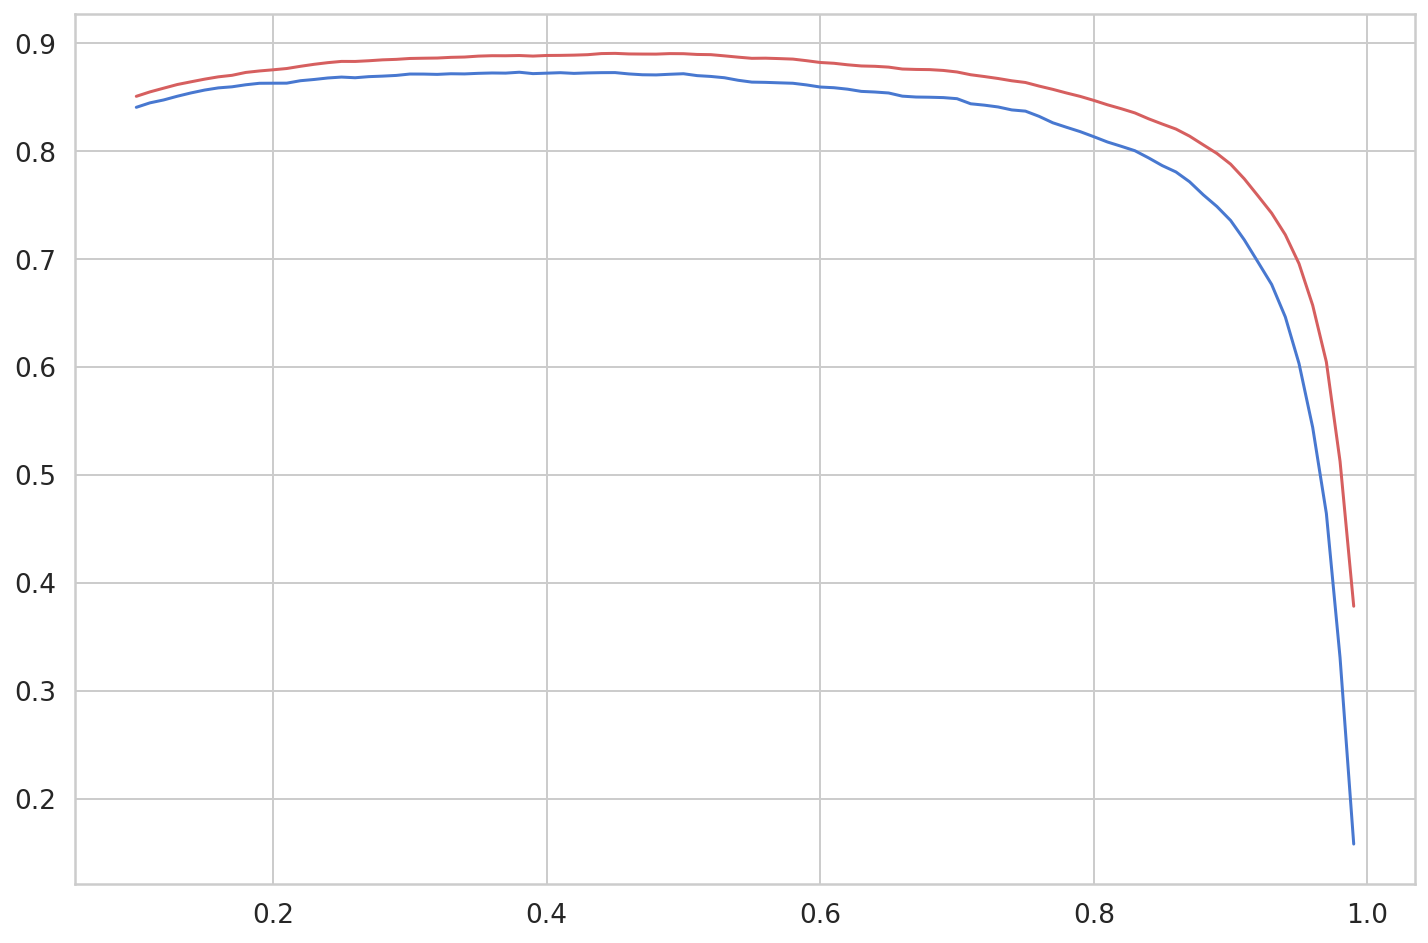

In [158]:
import seaborn as sns
import matplotlib.pyplot as plt

x = np.arange(10, 100, 1)/100
y1 = np.array(micro_F1_Scores)
y2 = np.array(macro_F1_Scores)

plt.plot(x, y1, 'r')  
plt.plot(x, y2, 'b') 
plt.show()

In [159]:
max(micro_F1_Scores), np.argmax(micro_F1_Scores), x[42]

(0.8905395646342721, 35, 0.52)

In [160]:
Annotation_size = {
    "Type_1": [],
    "Type_2": [],
    "Type_3": [],
    "Type_4g": []
}

In [161]:
for index, annotation in enumerate(labels):

  annotation = annotation.numpy()
  count = np.count_nonzero(annotation)
  if count == 1:
    Annotation_size["Type_1"].append(index)
  elif count == 2:
    Annotation_size["Type_2"].append(index)
  elif count == 3:
    Annotation_size["Type_3"].append(index)
  else:
    Annotation_size["Type_4g"].append(index)

#### Classification Reports based on annotation counts

In [162]:
predictions.shape

torch.Size([3423, 7])

In [163]:
# Annotation equals once

Type_1_predictions = predictions[Annotation_size["Type_1"]]
Type_1_labels = labels[Annotation_size["Type_1"]]

In [164]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.6, upper, lower)

print("classification report based on Annotation count equals one\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals one

                      precision    recall  f1-score   support

         Case Report     0.9565    0.7984    0.8703       248
           Diagnosis     0.8362    0.9604    0.8940       303
Epidemic Forecasting     0.8909    0.8750    0.8829        56
           Mechanism     0.6795    0.8548    0.7571        62
          Prevention     0.9480    0.9623    0.9551      1194
        Transmission     0.4667    0.8333    0.5983        42
           Treatment     0.7507    0.9107    0.8230       291

           micro avg     0.8763    0.9290    0.9019      2196
           macro avg     0.7898    0.8850    0.8258      2196
        weighted avg     0.8892    0.9290    0.9053      2196
         samples avg     0.8910    0.9290    0.9034      2196



In [165]:
# Annotation equals twice

Type_1_predictions = predictions[Annotation_size["Type_2"]]
Type_1_labels = labels[Annotation_size["Type_2"]]

In [166]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals two\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals two

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9207    0.8398    0.8784       387
Epidemic Forecasting     0.9250    0.7475    0.8268        99
           Mechanism     0.9333    0.9010    0.9169       404
          Prevention     0.9475    0.8525    0.8975       339
        Transmission     0.9646    0.8377    0.8967       228
           Treatment     0.9865    0.8759    0.9279       669

           micro avg     0.9501    0.8603    0.9030      2126
           macro avg     0.8111    0.7221    0.7635      2126
        weighted avg     0.9530    0.8603    0.9039      2126
         samples avg     0.9512    0.8603    0.8870      2126



In [167]:
# Annotation equals thrice

Type_1_predictions = predictions[Annotation_size["Type_3"]]
Type_1_labels = labels[Annotation_size["Type_3"]]

In [168]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals three\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals three

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     0.9059    0.7404    0.8148       104
Epidemic Forecasting     0.8333    0.4545    0.5882        11
           Mechanism     0.9697    0.7619    0.8533        84
          Prevention     0.9318    0.6308    0.7523        65
        Transmission     0.9444    0.7500    0.8361        68
           Treatment     0.9848    0.6701    0.7975        97

           micro avg     0.9439    0.7063    0.8080       429
           macro avg     0.7957    0.5725    0.6632       429
        weighted avg     0.9444    0.7063    0.8065       429
         samples avg     0.9481    0.7063    0.7868       429



In [169]:
# Annotation equals more than 4

Type_1_predictions = predictions[Annotation_size["Type_4g"]]
Type_1_labels = labels[Annotation_size["Type_4g"]]

In [170]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals more than 4\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

classification report based on Annotation count equals more than 4

                      precision    recall  f1-score   support

         Case Report     0.0000    0.0000    0.0000         0
           Diagnosis     1.0000    0.7619    0.8649        21
Epidemic Forecasting     0.0000    0.0000    0.0000         0
           Mechanism     1.0000    0.7222    0.8387        18
          Prevention     1.0000    0.6000    0.7500        15
        Transmission     1.0000    0.5000    0.6667        14
           Treatment     0.9231    0.6667    0.7742        18

           micro avg     0.9828    0.6628    0.7917        86
           macro avg     0.7033    0.4644    0.5563        86
        weighted avg     0.9839    0.6628    0.7881        86
         samples avg     0.9841    0.6667    0.7639        86



In [178]:
pmid = val_df["pmid"].to_frame()

In [179]:
pmid.shape

(3423, 1)

In [184]:
prediction_df = pd.DataFrame(predictions.numpy(), columns=LABEL_COLUMNS)
label_df = pd.DataFrame(labels.numpy(), columns=LABEL_COLUMNS)

In [185]:
pred_df["pmid"] = pmid
label_df["pmid"] = pmid

In [193]:
prediction_df.to_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/intro_prediction.csv", index=False)
label_df.to_csv("drive/MyDrive/Biocreative/Biocreative/datasets/specter_results/intro_labels.csv", index=False)

#### model prediction and annotation segregation on baseline standards

In [ ]:
gold_predictions = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/baseline/prediction_label_samples.csv")
gold_predictions = gold_predictions.reindex(columns=LABEL_COLUMNS)
# gold_predictions = gold_predictions.drop(["PMID"], axis=1)
gold_labels = pd.read_csv("drive/MyDrive/Biocreative/Biocreative/datasets/baseline/goldstandard_label_samples.csv")
gold_labels = gold_labels.reindex(columns=LABEL_COLUMNS)
# gold_labels = gold_labels.drop(["PMID"], axis=1)

In [ ]:
gold_predictions = gold_predictions.values.tolist()
gold_labels = gold_labels.values.tolist()

In [ ]:
Annotation_size = {
    "Type_1": [],
    "Type_2": [],
    "Type_3": [],
    "Type_4g": []
}

In [ ]:
for index, annotation in enumerate(gold_labels):

  annotation = np.array(annotation)
  count = np.count_nonzero(annotation)
  if count == 1:
    Annotation_size["Type_1"].append(index)
  elif count == 2:
    Annotation_size["Type_2"].append(index)
  elif count == 3:
    Annotation_size["Type_3"].append(index)
  else:
    Annotation_size["Type_4g"].append(index)

In [ ]:
gold_predictions = torch.tensor(gold_predictions)
gold_labels = torch.tensor(gold_labels)

In [ ]:
# Annotation equals once

Type_1_predictions = gold_predictions[Annotation_size["Type_1"]]
Type_1_labels = gold_labels[Annotation_size["Type_1"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals one\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

In [ ]:
# Annotation equals twice

Type_1_predictions = gold_predictions[Annotation_size["Type_2"]]
Type_1_labels = gold_labels[Annotation_size["Type_2"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals two\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

In [ ]:
# Annotation equals thrice

Type_1_predictions = gold_predictions[Annotation_size["Type_3"]]
Type_1_labels = gold_labels[Annotation_size["Type_3"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals three\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)

In [ ]:
# Annotation equals more than 4

Type_1_predictions = gold_predictions[Annotation_size["Type_4g"]]
Type_1_labels = gold_labels[Annotation_size["Type_4g"]]

In [ ]:
y_pred = Type_1_predictions.numpy()
y_true = Type_1_labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > 0.5, upper, lower)

print("classification report based on Annotation count equals more than 4\n")

print(
    classification_report(
        y_true,
        y_pred,
        digits=4,
        target_names=LABEL_COLUMNS,
        zero_division=0
    )
)